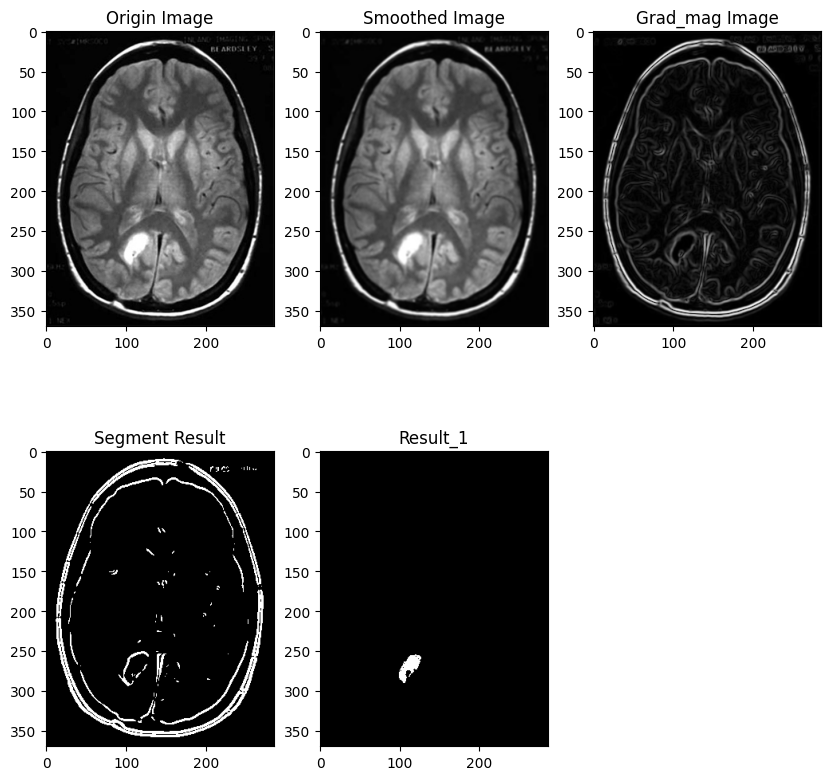

In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
data = np.load('lab5.npy')
P = data.shape[0]
Q = data.shape[1]

# 3x3平滑滤波器
smoothed = cv.blur(data, (3, 3))

# 定义Sobel梯度算子
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

# 应用Sobel算子计算梯度幅值
grad_x = cv.filter2D(smoothed, -1, sobel_x)
grad_y = cv.filter2D(smoothed, -1, sobel_y)
grad_mag = np.sqrt(grad_x**2 + grad_y**2)

# 应用阈值得到二值化掩模
T = 185
mask = np.zeros_like(grad_mag)  #初始化一个大小相同的全0矩阵
mask[grad_mag > T] = 255

plt.subplot(2,3,1)
plt.title("Origin Image")
plt.imshow(data,cmap='gray')

plt.subplot(2,3,2)
plt.title("Smoothed Image")
plt.imshow(smoothed,cmap='gray')

plt.subplot(2,3,3)
plt.title("Grad_mag Image")
plt.imshow(grad_mag,cmap='gray')

plt.subplot(2,3,4)
plt.title("Segment Result")
plt.imshow(mask,cmap='gray')

Img_final = data - mask
Img_final[Img_final < 250] = 0

# 去除brain边界灰度值较高的部分，获取中间病变部分
Img_final[:,[i for i in range(Q) if i < 80 or i > 150 ]] = 0
Img_final[[i for i in range(P) if i > 300 or i < 240],:] = 0

# 输出最终病变图像
plt.subplot(2,3,5)
plt.title("Result_1")
plt.imshow(Img_final,cmap='gray')

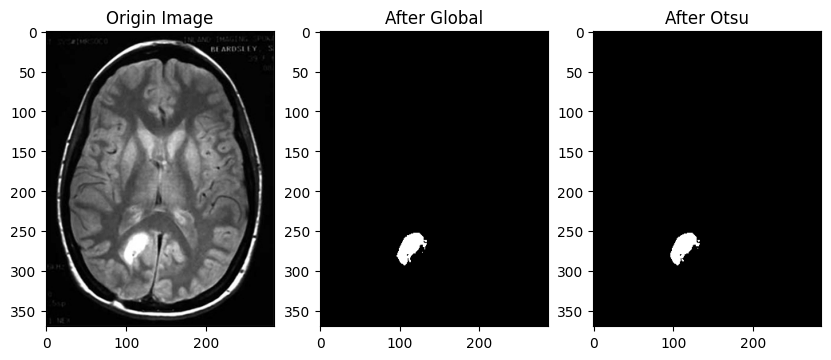

In [2]:
plt.figure(figsize=(10, 10))
data = np.load('lab5.npy')

plt.subplot(2,3,1)
plt.title("Origin Image")
plt.imshow(data,cmap='gray')

# 全局阈值分割
# 计算图像的平均灰度值

# 由于原图中灰度分布在病变部位不是十分明显，故只对病变部位大致区域的部分(80:135,240:300)进行全局阈值分割与Otsu最优阈值分割
# 输出图像时再将这个区域之外的内容灰度值置0
data[:,[i for i in range(Q) if i < 80 or i > 135]] = 255
data[[i for i in range(P) if i > 300 or i < 240],:] = 255

mean_val = np.mean(data)
# 阈值T，预定值T0
T = int(mean_val)
T0 = 1
# 迭代计算阈值，直到收敛
while True:
    # 计算两个区域的平均灰度值
    G1 = np.mean(data[data < T])
    G2 = np.mean(data[data >= T])

    new_T = int((G1 + G2) / 2)
    
    # 如果新的阈值与旧的阈值相同，则停止迭代
    if np.abs(T - new_T) <= T0:
        break
    T = new_T

# 应用阈值得到二值化掩模
global_mask = np.zeros_like(data)
data[:,[i for i in range(Q) if i < 80 or i > 135 ]] = 0
data[[i for i in range(P) if i > 300 or i < 240],:] = 0
global_mask[data >= T] = 255

# Otsu最优阈值分割
data[:,[i for i in range(Q) if i < 80 or i > 135]] = 255
data[[i for i in range(P) if i > 300 or i < 240],:] = 255
# 计算图像的直方图
hist, bins = np.histogram(data, bins=256, range=(0, 256))
# 计算图像的像素总数
total_pixels = P * Q
hist = hist / total_pixels
# 初始化最大方差和最优阈值
max_var = 0
optimal_T = 0

# 遍历所有可能的阈值
for I in range(256):
    # 计算两个区域的像素数和像素值的和
    P1 = np.sum(hist[:I])
    P2 = 1 - P1
    # 累计均值
    m_k = np.sum(hist[:I] * np.arange(I))
    # 全局均值
    m_G = np.sum(hist[:] * np.arange(256))

    if(P2 == 0 or P1 == 0):
        continue
    
    # 计算类间方差
    var = (m_G * P1 - m_k)**2 / P1 / P2
    # 如果类间方差更大，则更新最大方差和最优阈值
    if var > max_var:
        max_var = var
        optimal_T = I

# 应用阈值得到二值化掩模
otsu_mask = np.zeros_like(data)
data[:,[i for i in range(Q) if i < 80 or i > 135 ]] = 0
data[[i for i in range(P) if i > 300 or i < 240],:] = 0
otsu_mask[data >= optimal_T] = 255



plt.subplot(2,3,2)
plt.title("After Global")
plt.imshow(global_mask,cmap='gray')

plt.subplot(2,3,3)
plt.title("After Otsu")
plt.imshow(otsu_mask,cmap='gray')




病变体积为：608mm^3


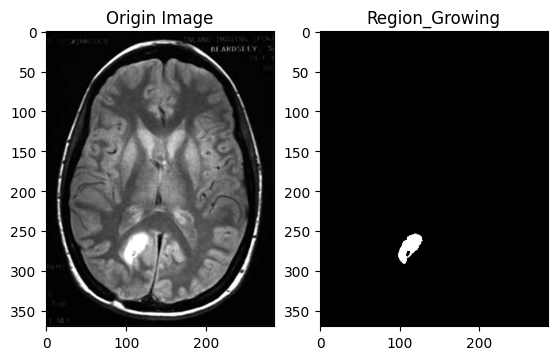

In [82]:

plt.figure(figsize=(10, 10))
data = np.load('lab5.npy')

plt.subplot(2,3,1)
plt.title("Origin Image")
plt.imshow(data,cmap='gray')

# ----------------------------------
# 区域生长
# ----------------------------------

# 选择种子点(于病变部位区域内)
seed_point = (260, 110)
# 初始化二值化掩模
region_growing_mask = np.zeros_like(data)
# 初始化队列
queue = [seed_point]
# 设置阈值
T = 230
# 执行区域生长
while len(queue) > 0:
    # 取出队列中的下一个点
    point = queue.pop(0)
    # 如果该点在病变区域内且未被访问过，则标记为病变区域
    if data[point] > T and region_growing_mask[point] == 0:
        region_growing_mask[point] = 255
        # 将相邻的点加入队列
        if point[0] > 0:
            queue.append((point[0]-1, point[1]))
        if point[0] < data.shape[0]-1:
            queue.append((point[0]+1, point[1]))
        if point[1] > 0:
            queue.append((point[0], point[1]-1))
        if point[1] < data.shape[1]-1:
            queue.append((point[0], point[1]+1))

# 计算病变体积
lesion_volume = np.count_nonzero(region_growing_mask) * 1 * 1 * 1

plt.subplot(2,3,2)
plt.title("Region_Growing")
plt.imshow(region_growing_mask,cmap='gray')

print("病变体积为：" + str(lesion_volume) + "mm^3")


d:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


病变体积为：802mm^3


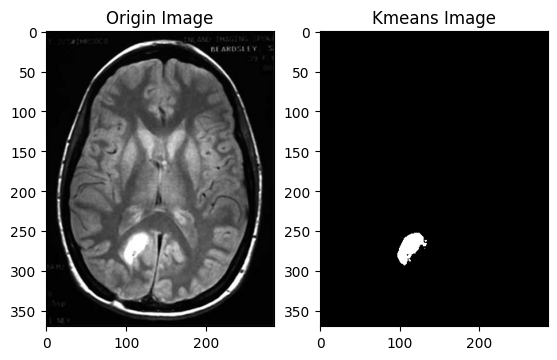

In [42]:
from sklearn.cluster import KMeans

plt.figure(figsize=(10, 10))
data = np.load('lab5.npy')

plt.subplot(2,3,1)
plt.title("Origin Image")
plt.imshow(data,cmap='gray')

# -------------------
# K均值聚类
# -------------------

# 对病变部位大致区域的部分(80:135,240:300)作Kmeans聚类
# 将图像转换为2D像素数组并执行K均值聚类
data[:,[i for i in range(Q) if i < 80 or i > 135 ]] = 255
data[[i for i in range(P) if i > 300 or i < 240],:] = 255
x = data.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X=x)

# 将聚类标签转换为图像
kmeans_labels = kmeans.labels_.reshape(data.shape)

# 选择平均灰度值较高的标签作为病变区域
if np.mean(data[kmeans_labels == 0]) > np.mean(data[kmeans_labels == 1]):
    kmeans_mask = (kmeans_labels == 0).astype(np.uint8) * 255
else:
    kmeans_mask = (kmeans_labels == 1).astype(np.uint8) * 255

kmeans_mask[:,[i for i in range(Q) if i < 80 or i > 135 ]] = 0
kmeans_mask[[i for i in range(P) if i > 300 or i < 240],:] = 0
# 计算病变体积
lesion_volume_kmeans = np.count_nonzero(kmeans_mask) * 1 * 1 * 1
print("病变体积为：" + str(lesion_volume_kmeans) + "mm^3")

plt.subplot(2,3,2)
plt.title("Kmeans Image")
plt.imshow(kmeans_mask,cmap='gray')

病变体积为：729.0mm^3


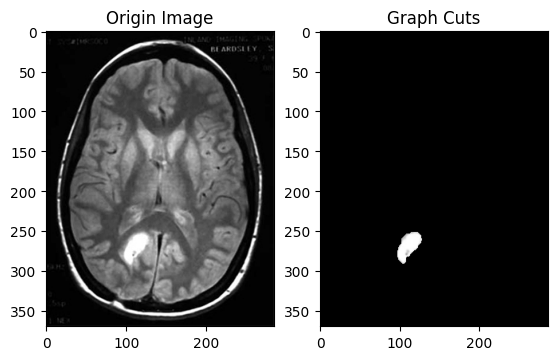

In [71]:
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel
from skimage.segmentation import watershed
from scipy import ndimage as ndi

plt.figure(figsize=(10, 10))
data = np.load('lab5.npy')

plt.subplot(2,3,1)
plt.title("Origin Image")
plt.imshow(data,cmap='gray')

# ----------------------------
# 图割
# ----------------------------
# 执行图割分割

img = cv.imread('lab5.png')

# 定义矩形，表示待分割区域
rect = (30,140,215,230)
# (30,150,215,230)
# 定义掩码，初始化为0
mask = np.zeros(img.shape[:2], np.uint8)

# 定义前景和背景模型，初始化为0
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
# 进行图像分割
cv.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)

# 将掩码中为0的像素设置为背景，其余像素设置为前景
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
# 将掩码应用于原始图像，提取前景
img = img * mask2[:, :, np.newaxis]
img[:,[i for i in range(Q) if i < 80 or i > 135 ]] = 0
img[[i for i in range(P) if i > 300 or i < 240],:] = 0
# 显示结果
plt.subplot(2,3,2)
plt.title("Graph Cuts")
plt.imshow(img,cmap='gray')

# graphcuts_mask
# 计算病变体积
lesion_volume_graphcuts = np.count_nonzero(img) /3 * 1 * 1 * 1
print("病变体积为：" + str(lesion_volume_graphcuts) + "mm^3")


病变体积为：730mm^3


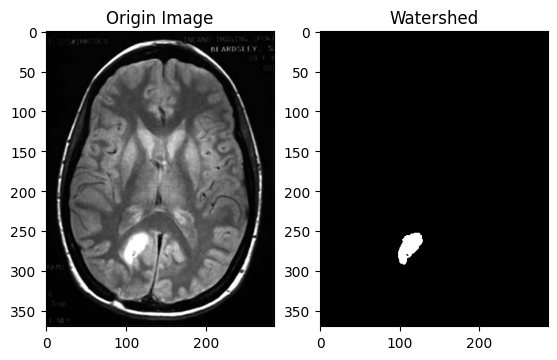

In [87]:
plt.figure(figsize=(10, 10))
data = np.load('lab5.npy')

plt.subplot(2,3,1)
plt.title("Origin Image")
plt.imshow(data,cmap='gray')

# ----------------------
# 分水岭分割
# ----------------------

# 执行分水岭分割
elevation_map = sobel(data)
markers = np.zeros_like(data)
markers[data < 150] = 1
markers[data > 220] = 2
labels = watershed(elevation_map, markers=markers)

# 选择平均灰度值较高的标签作为病变区域
if np.mean(data[labels == 1]) > np.mean(data[labels == 2]):
    watershed_mask = (labels == 1).astype(np.uint8) * 255
else:
    watershed_mask = (labels == 2).astype(np.uint8) * 255


watershed_mask[:,[i for i in range(Q) if i < 80 or i > 135 ]] = 0
watershed_mask[[i for i in range(P) if i > 300 or i < 240],:] = 0


plt.subplot(2,3,2)
plt.title("Watershed")
plt.imshow(watershed_mask,cmap='gray')

# 计算病变体积
lesion_volume_watershed = np.count_nonzero(watershed_mask) * 1 * 1 * 1
print("病变体积为：" + str(lesion_volume_watershed) + "mm^3")


brain体积为：89342mm^3


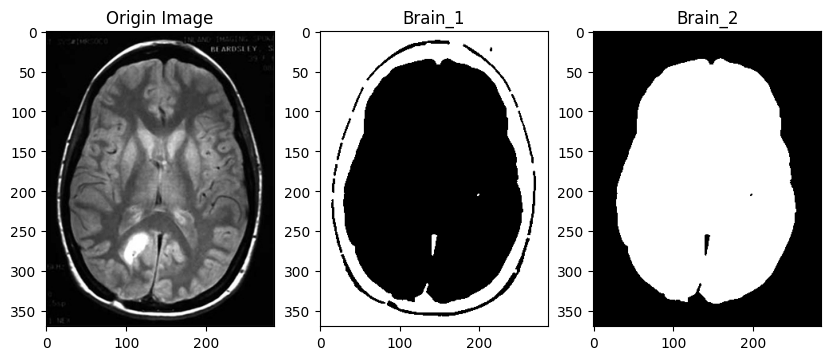

In [110]:
# 计算大脑的体积（除去头骨和脂肪）
plt.figure(figsize=(10, 10))
data = np.load('lab5.npy')

plt.subplot(2,3,1)
plt.title("Origin Image")
plt.imshow(data,cmap='gray')

# 先执行分水岭分割
elevation_map = sobel(data)
markers = np.zeros_like(data)
markers[data < 20] = 1
markers[data > 150] = 2
labels = watershed(elevation_map, markers=markers)

if np.mean(data[labels == 1]) < np.mean(data[labels == 2]):
    final_mask_1 = (labels == 1).astype(np.uint8) * 255
else:
    final_mask_1 = (labels == 2).astype(np.uint8) * 255


# watershed_mask[:,[i for i in range(Q) if i < 80 or i > 135 ]] = 0
# watershed_mask[[i for i in range(P) if i > 300 or i < 240],:] = 0

# 经历第一边分水岭分割，获得如图所示
plt.subplot(2,3,2)
plt.title("Brain_1")
plt.imshow(final_mask_1,cmap='gray')


# 其次执行区域生长

# 选择种子点(于病变部位区域内)
seed_point = (200, 130)
# 初始化二值化掩模
final_mask_2 = np.zeros_like(final_mask_1)
# 初始化队列
queue = [seed_point]
# 设置阈值
T = 250
# 执行区域生长
while len(queue) > 0:
    # 取出队列中的下一个点
    point = queue.pop(0)
    # 如果该点在病变区域内且未被访问过，则标记为病变区域
    if final_mask_1[point] < T and final_mask_2[point] == 0:
        final_mask_2[point] = 255
        # 将相邻的点加入队列
        if point[0] > 0:
            queue.append((point[0]-1, point[1]))
        if point[0] < data.shape[0]-1:
            queue.append((point[0]+1, point[1]))
        if point[1] > 0:
            queue.append((point[0], point[1]-1))
        if point[1] < data.shape[1]-1:
            queue.append((point[0], point[1]+1))

# 获得大脑区域的图片（白色）
plt.subplot(2,3,3)
plt.title("Brain_2")
plt.imshow(final_mask_2,cmap='gray')

# 计算brain体积
brain_V = np.count_nonzero(watershed_mask) * 1 * 1 * 1
print("brain体积为：" + str(brain_V) + "mm^3")

# Disclosure
* 1.sklearn聚类算法之Kmeans https://blog.csdn.net/qq_45448654/article/details/120848342
* 2.数字图像处理（十）图像分割之全局阈值处理、otsu阈值处理、多阈值处理、可变阈值处理、多变量阈值处理 https://blog.csdn.net/hjxu2016/article/details/80766949/
* 3.OpenCV入门（九）——图像分割技术之分水岭分割 https://blog.csdn.net/Alkaid2000/article/details/124640760
* 4.基于区域生长的图像分割算法！ https://blog.csdn.net/weixin_37737254/article/details/124008619
* 5.从GraphCut到GrabCut的OpenCV实现：图像分割 https://zhuanlan.zhihu.com/p/29781759

